<a href="https://colab.research.google.com/github/Rohanator2314/COMP3710-demo-2/blob/main/COMP37101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch

# 1. Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Set parameters for the signal
N = 2048 # Number of sample points
T = 1.0 # Duration of the signal in seconds
f0 = 1 # Fundamental frequency of the square wave in Hz
# List of harmonic numbers used to construct the square wave
harmonics = [ 2*x + 1 for x in range(50) ]

In [ ]:
# Define the square wave function
def square_wave(t):
  return np.sign(np.sin(2.0 * np.pi * f0 * t))

def square_wave_torch(t_tensor):
  return torch.sign(torch.sin(2.0 * torch.pi * f0 * t_tensor))

# Fourier series approximation of the square wave
def square_wave_fourier(t, f0, N):
  result = np.zeros_like(t)
  for k in range(N):
    # The Fourier series of a square wave contains only odd harmonics.
    n = 2 * k + 1
    # Add harmonics to reconstruct the square wave.
    result += np.sin(2 * np.pi * n * f0 * t) / n
  return (4 / np.pi) * result

def square_wave_fourier_torch(t_tensor, f0, N_harmonics):
  result = torch.zeros_like(t_tensor, dtype=torch.float32, device=device)
  for k in range(N_harmonics):
    n = 2 * k + 1
    result += torch.sin(2 * torch.pi * n * f0 * t_tensor) / n
  return (4 / torch.pi) * result

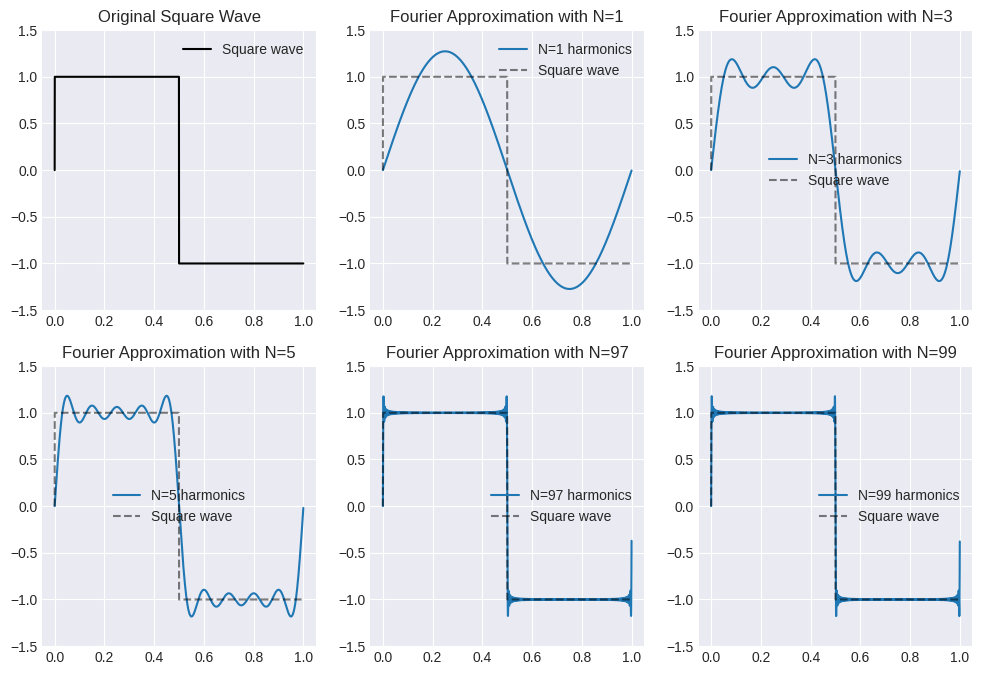

In [ ]:
# Create the time vector
# np.linspace generates evenly spaced numbers over a specified interval.
# We use endpoint=False because the interval is periodic.
t = np.linspace(0.0, T, N, endpoint=False)
t_tensor = torch.tensor(t, dtype=torch.float32).to(device)

# Generate the original square wave
square = square_wave_torch(t_tensor).to(device)
plt.figure(figsize=(12, 8))

# Plot the original square wave
t = t_tensor.cpu().numpy()
square = square.cpu().numpy()

plt.subplot(2, 3, 1)
plt.plot(t, square, 'k', label="Square wave")
plt.title("Original Square Wave")
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.legend()

# Plot Fourier reconstructions under different number of harmonics
for i, Nh in enumerate(harmonics[:3], start=2):
  plt.subplot(2, 3, i)
  y = square_wave_fourier(t, f0, Nh)
  plt.plot(t, y, label=f"N={Nh} harmonics")
  plt.plot(t, square, 'k--', alpha=0.5, label="Square wave")
  plt.title(f"Fourier Approximation with N={Nh}")
  plt.ylim(-1.5, 1.5)
  plt.grid(True)
  plt.legend()

# Plot Fourier reconstructions under different number of harmonics
for i, Nh in enumerate(harmonics[48:], start=2):
  plt.subplot(2, 3, i+3)
  y = square_wave_fourier(t, f0, Nh)
  plt.plot(t, y, label=f"N={Nh} harmonics")
  plt.plot(t, square, 'k--', alpha=0.5, label="Square wave")
  plt.title(f"Fourier Approximation with N={Nh}")
  plt.ylim(-1.5, 1.5)
  plt.grid(True)
  plt.legend()

plt.show()

In [ ]:
def naive_dft(x):
    """
    Computes the Discrete Fourier Transform (DFT) of a 1D signal.

    This is a "naïve" implementation that directly follows the DFT formula,
    which has a time complexity of O(N^2).

    Args:
        x (np.ndarray): The input signal, a 1D NumPy array.

    Returns:
        np.ndarray: The complex-valued DFT of the input signal.
    """
    N = len(x)
    # Create an empty array of complex numbers to store the DFT results
    X = np.zeros(N, dtype=np.complex128)

    # Iterate through each frequency bin (k)
    for k in range(N):
        # For each frequency bin, sum the contributions from all input samples (n)
        for n in range(N):
            # The core DFT formula: x[n] * e^(-2j * pi * k * n / N)
            angle = -2j * np.pi * k * n / N
            X[k] += x[n] * np.exp(angle)

    return X


In [62]:
@torch.no_grad()
def naive_dft_torch(x_tensor):
    """
    Computes the Discrete Fourier Transform (DFT) of a 1D signal using PyTorch.

    This is a "naïve" implementation that directly follows the DFT formula,
    which has a time complexity of O(N^2).

    Args:
        x_tensor (torch.Tensor): The input signal, a 1D PyTorch tensor on the appropriate device.

    Returns:
        torch.Tensor: The complex-valued DFT of the input signal on the same device.
    """
    # Ensure complex128 for apples-to-apples with NumPy
    x = x_tensor.to(torch.complex128)
    N = x.shape[0]
    device = x.device

    n = torch.arange(N, device=device).to(torch.float64)
    k = n.view(-1, 1)  # column vector
    # Twiddle matrix W[k, n] = exp(-2j*pi*k*n/N)
    W = torch.exp(-2j * torch.pi * (k @ (n.view(1, -1))) / N)  # (N,N) complex128

    return W @ x  # (N,)

In [63]:
# Construct a square wave using 50 harmonics
signal = square_wave_fourier(t, f0, 50)
# Convert signal to PyTorch tensor
signal_tensor = square_wave_fourier_torch(t_tensor, f0, 50).to(device)

# Time the naïve DFT implementation
start_time_naive = time.time()
dft_result = naive_dft(signal)
end_time_naive = time.time()
naive_duration = end_time_naive - start_time_naive

# Time the PyTorch naïve DFT implementation
start_time_naive_torch = time.time()
dft_result_torch = naive_dft_torch(signal_tensor)
end_time_naive_torch = time.time()
naive_torch_duration = end_time_naive_torch - start_time_naive_torch

# Time NumPy's FFT implementation
start_time_fft = time.time()
fft_result = np.fft.fft(signal)
end_time_fft = time.time()
fft_duration = end_time_fft - start_time_fft

# 3. Print Timings and Verification
print("--- DFT/FFT Performance Comparison ---")
print(f"Naïve DFT (NumPy) Execution Time: {naive_duration:.6f} seconds")
print(f"Naïve DFT (PyTorch) Execution Time: {naive_torch_duration:.6f} seconds")
print(f"NumPy FFT Execution Time: {fft_duration:.6f} seconds")

# It's possible for the FFT to be so fast that the duration is 0.0, so we handle that case.
if fft_duration > 0:
  print(f"NumPy FFT is approximately {naive_duration / fft_duration:.2f} times faster than Naïve DFT (NumPy).")
else:
  print("NumPy FFT was too fast to measure a significant duration difference compared to Naïve DFT (NumPy).")

if naive_torch_duration > 0:
  print(f"Naïve DFT (NumPy) is approximately {naive_duration / naive_torch_duration:.2f} times faster than Naïve DFT (PyTorch).")
else:
  print("Naïve DFT (PyTorch) was too fast to measure a significant duration difference compared to Naïve DFT (NumPy).")


# Check if our implementation is close to NumPy's result
# np.allclose is used for comparing floating-point arrays.
# Need to move PyTorch result back to CPU for comparison with NumPy
print(f"\nOur Naïve DFT (NumPy) implementation is close to NumPy's FFT: {np.allclose(dft_result, fft_result)}")
print(f"Our Naïve DFT (PyTorch) implementation is close to NumPy's FFT: {np.allclose(dft_result_torch.cpu().numpy(), fft_result)}")

--- DFT/FFT Performance Comparison ---
Naïve DFT (NumPy) Execution Time: 6.824755 seconds
Naïve DFT (PyTorch) Execution Time: 0.415402 seconds
NumPy FFT Execution Time: 0.000212 seconds
NumPy FFT is approximately 32163.03 times faster than Naïve DFT (NumPy).
Naïve DFT (NumPy) is approximately 16.43 times faster than Naïve DFT (PyTorch).

Our Naïve DFT (NumPy) implementation is close to NumPy's FFT: True
Our Naïve DFT (PyTorch) implementation is close to NumPy's FFT: False


In [64]:
# 4. Prepare for Plotting
# Generate the frequency axis for the plot.
# np.fft.fftfreq returns the DFT sample frequencies.
# We only need the first half of the frequencies (the positive ones) due to symmetry.
xf = np.fft.fftfreq(N, d=T/N)[:N//2]
# We normalize the magnitude by N and multiply by 2 to get the correct amplitude.
magnitude = 2.0/N * np.abs(dft_result[0:N//2])

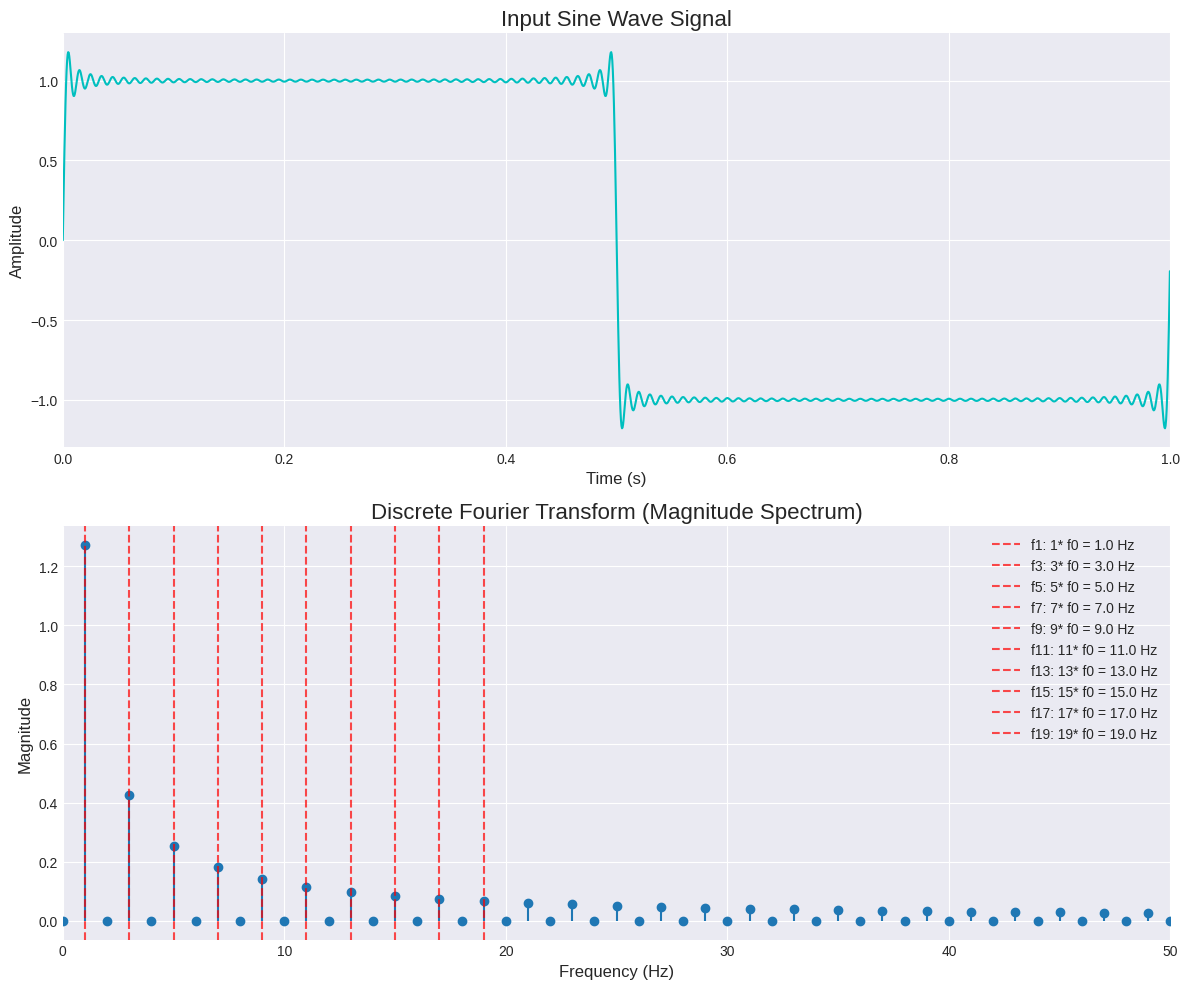

In [65]:
# 5. Visualize the Results
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
# Plot the original time-domain signal
ax1.plot(t, signal, color='c')
ax1.set_title('Input Sine Wave Signal', fontsize=16)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set_xlim(0, 1.0) # Show a few cycles of the sine wave
ax1.grid(True)

# Plot the frequency-domain signal (magnitude of the DFT)
ax2.stem(xf, magnitude, basefmt=" ")
ax2.set_title(
  'Discrete Fourier Transform (Magnitude Spectrum)',
  fontsize=16
)
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Magnitude', fontsize=12)
ax2.set_xlim(0, 50) # Focus on lower frequencies
ax2.grid(True)

# Add vertical lines for the first ten frequencies
for i in range(20):
  if i < len(xf) and i % 2 == 1: # Only plot odd harmonics
    ax2.axvline(
      xf[i], color='r', linestyle='--', alpha=0.7,
      label=f'f{i}: {i}* f0 = {xf[i]:.1f} Hz'
    )
# Only show labels for first 3 frequencies to avoid cluttering
ax2.legend()
plt.tight_layout()
plt.show()
